In [1]:
%pylab inline
%load_ext pyspecdata.ipy
from pyspecdata import *
from Instruments import *
from serial.tools.list_ports import comports
import serial

Populating the interactive namespace from numpy and matplotlib


the following just sets up a log file -- ignore
(copy of pyspecdata init_logging)

In [2]:
import logging,os
init_logging() # from pyspecdata --> goes to ~/pyspecdata.log
def strm(*args):
    return ' '.join([str(j) for j in args])
FORMAT = "--> %(filename)s(%(lineno)s):%(name)s %(funcName)20s %(asctime)20s\n%(levelname)s: %(message)s"
logger = logging.getLogger('GDS_scope')
logger.setLevel(logging.DEBUG)

first, print out the available instruments

In [3]:
print "These are the instruments available:"
SerialInstrument(None)
print "done printing available instruments"

These are the instruments available:


GW INSTEK,AFG-2225,SN:GEQ904866,V2.05

GW,GDS-3254,GEQ110185,V1.25

done printing available instruments


Note that I can now use ``SerialInstrument`` in place of ``serial.Serial``, except that ``SerialInstrument`` accepts a string identifying the instrument, and adds and changes various functions inside the class to make them more convenient.

try to connect to GDS and print idn

In [4]:
with SerialInstrument('GDS-3254') as s:
    print s.respond('*idn?')

GW,GDS-3254,GEQ110185,V1.25



try to connect to AFG and print idn

In [5]:
with SerialInstrument('AFG-2225') as s:
    print s.respond('*idn?')

GW INSTEK,AFG-2225,SN:GEQ904866,V2.05



The previous cell only ***defines*** the function ``retrieve_waveform``.  Now I have to actually call (run) it!:

**before running this, send something interesting to the scope**

In [6]:
with GDS_scope() as g:
    data = g.waveform(ch=2)

At this point, I went through and inspected `data.other_info` (`other_info` is an attribute of `nddata` whose elements can be retrieved with `get_prop`) to see what info was left in the parameter dictionary, and if I could use and pop anything else from the dictionary.

In [7]:
data.other_info

print data.get_prop('Memory Length')
print type(data.get_prop('Memory Length'))
print data.get_prop('Horizontal Scale')
print type(data.get_prop('Horizontal Scale'))

25000
<type 'int'>
0.0002
<type 'float'>


Now, we can look at the data quick and dirty

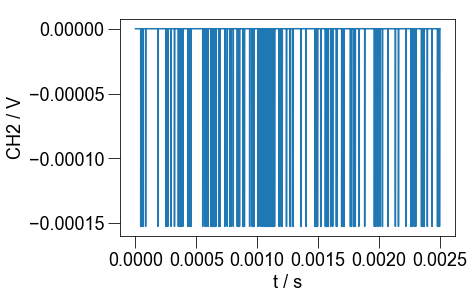

In [8]:
data

We can select a portion of the data:

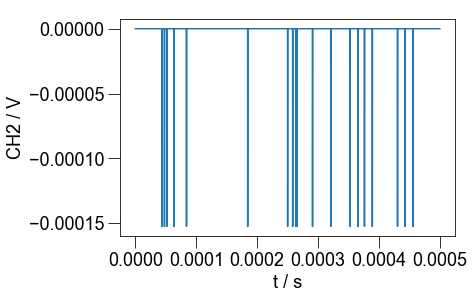

In [9]:
data['t':(0,5e-4)]

Manually average a bunch of times, just because I'm curious how long it takes, and because it's an easy way of getting around the 8 bit resolution

%time gives the execution time -- %%timeit will run multiple and find best

In [10]:
%%time
n_shots = 20
with GDS_scope() as g:
    for j in range(n_shots):
        if j == 0:
            data = g.waveform(ch=2)
        else:
            data += g.waveform(ch=2)
    data /= n_shots


data['t':(0,5e-4)]

IndexError: string index out of range

the following is just so I can also run this as a script

In [ ]:
show()